# <font color='darkblue'>__04 · TinyFlux: Workshop Events (Posts/Likes/Comments/Follows)__</font>

--------------------
__[1. Import Python Libraries und Settings](#import_libraries)__<br>
__[2. Define functions (mostly optional)](#define_functions)__<br>
__[3. Initialize the TinyFlux database](#initialize_db)__<br>
__[4. Importing a CSV file and show first descriptive statistics](#import_describe)__<br>
__[5. Writing a CSV file into TinyFlux](#write_csv_db)__<br>
__[6. Querying](#querying)__<br>
--------------------

#### <a id='import_libraries'></a>
## <font color='darkblue'>__1. Import Python Libraries und Settings__</font>

In [1]:
# Libraries
import pandas as pd
from pathlib import Path
import os, json, pandas as pd
from datetime import datetime, timedelta, timezone
from tinyflux import TinyFlux, Point, TimeQuery, TagQuery, FieldQuery
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from dateutil import parser as dateparser
from datetime import timezone

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

C:\Users\pell\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### <a id='define_functions'></a>
## <font color='darkblue'>__2. Define functions (mostly optional)__</font>

### Define functions for importing, preparing and loading data into the database

In [2]:
def tinyflux_is_empty():
    try:
        next(iter(db.all()))
        return False
    except StopIteration:
        return True

def _normalize_time(t):
    # akzeptiert str oder pandas.Timestamp; liefert tz-aware UTC datetime
    if isinstance(t, str):
        t = pd.to_datetime(t, utc=True, errors='coerce')
    elif isinstance(t, pd.Timestamp):
        if t.tzinfo is None or t.tz is None:
            t = t.tz_localize('UTC')
        else:
            t = t.tz_convert('UTC')
    if t is None or (isinstance(t, pd.Timestamp) and pd.isna(t)):
        return None
    return t.to_pydatetime()

def _len_text(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return 1
    s = str(x)
    return max(1, len(s))

def insert_events_rows(rows):
    if not rows:
        print("Keine Events zum Einfügen.")
        return 0
    pts, seen = [], set()
    for r in rows:
        t = _normalize_time(r.get('time'))
        if t is None:
            continue
        key = (str(r.get('type')), str(r.get('user_id')), str(r.get('post_id')), str(t))
        if key in seen:
            continue
        seen.add(key)
        tags = {}
        if r.get('type') is not None:
            tags['type'] = str(r['type'])
        if r.get('user_id') is not None and pd.notna(r['user_id']):
            tags['user_id'] = str(int(r['user_id']))
        if r.get('post_id') is not None and pd.notna(r['post_id']):
            tags['post_id'] = str(int(r['post_id']))
        val = int(r.get('value', 1))
        pts.append(Point(time=t, measurement='events', tags=tags, fields={'value': val}))
    db.insert_multiple(pts)
    return len(pts)

def import_from_relational(REL):
    posts_csv    = REL / 'posts.csv'
    likes_csv    = REL / 'likes.csv'
    comments_csv = REL / 'comments.csv'
    follows_csv  = REL / 'follows.csv'

    have = [p for p in [posts_csv, likes_csv, comments_csv, follows_csv] if p.exists()]
    if not have:
        print("⚠️  Keine relationalen CSVs gefunden in:", REL)
        return 0

    rows = []

    # posts: field_value = Länge des Post-Texts (Zeichen)
    if posts_csv.exists():
        posts = pd.read_csv(posts_csv, parse_dates=['created_at'])
        text_col = 'text' if 'text' in posts.columns else None
        for _, r in posts.iterrows():
            rows.append({
                'time': r['created_at'],
                'type': 'post',
                'user_id': r.get('author_id', None),
                'post_id': r.get('post_id', None),
                'value': _len_text(r.get(text_col)) if text_col else 1
            })

    # likes: field_value = 1
    if likes_csv.exists():
        likes = pd.read_csv(likes_csv, parse_dates=['created_at'])
        for _, r in likes.iterrows():
            rows.append({
                'time': r['created_at'],
                'type': 'like',
                'user_id': r.get('user_id', None),
                'post_id': r.get('post_id', None),
                'value': 1
            })

    # comments: field_value = Länge des Kommentars (Zeichen)
    if comments_csv.exists():
        comments = pd.read_csv(comments_csv, parse_dates=['created_at'])
        text_col = 'text' if 'text' in comments.columns else None
        for _, r in comments.iterrows():
            rows.append({
                'time': r['created_at'],
                'type': 'comment',
                'user_id': r.get('user_id', None),
                'post_id': r.get('post_id', None),
                'value': _len_text(r.get(text_col)) if text_col else 1
            })

    # follows: field_value = 1
    if follows_csv.exists():
        follows = pd.read_csv(follows_csv, parse_dates=['since'])
        for _, r in follows.iterrows():
            rows.append({
                'time': r['since'],
                'type': 'follow',
                'user_id': r.get('src_user_id', None),
                'post_id': None,
                'value': 1
            })

    n = insert_events_rows(rows)
    print(f"Eingefügte Events: {n}")
    return n

### Define functions for creating a dataframe from query results into memory

In [3]:
# Define the function to transform the list of Point objects into a DataFrame
def point_to_row(p):
    tags = p.tags or {}
    fields = p.fields or {}
    return {
        "time": p.time,
        **{f"tag_{k}": v for k, v in tags.items()},
        **{f"field_{k}": v for k, v in fields.items()},
    }

def df_from_points(points):
    rows = [point_to_row(p) for p in points]
    return pd.DataFrame(rows)

def show(df, n=10):
    try:
        from IPython.display import display
        display(df.head(n))
    except Exception:
        print(df.head(n).to_string(index=False))


#### <a id='initialize_db'></a>
## <font color='darkblue'>__3. Initialize the TinyFlux database__</font>

In [4]:
# --- Robuste Pfaderkennung (aktuelles Verzeichnis ODER Parent mit data/…) ---
CWD = Path('.').resolve()
candidates = [CWD, CWD.parent]
BASE = None
for root in candidates:
    if (root / 'data').exists():
        BASE = root
        break
if BASE is None:
    BASE = CWD
    print("⚠️  Kein data/-Ordner gefunden; benutze CWD:", BASE)

TS  = BASE / 'data' / 'timeseries'
REL = BASE / 'data' / 'relational'
DOC = BASE / 'data' / 'document'

DB_PATH = TS / 'tinyflux_db.csv'
os.makedirs(TS, exist_ok=True)

print('Notebook base:', BASE)
print('TinyFlux DB :', DB_PATH)

# TinyFlux DB öffnen/erzeugen
db = TinyFlux(str(DB_PATH))


Notebook base: C:\Users\pell\Documents\3__UNTERRICHT_STUDENTENBETREUUNG\MSc_WI\DataScience\HS25
TinyFlux DB : C:\Users\pell\Documents\3__UNTERRICHT_STUDENTENBETREUUNG\MSc_WI\DataScience\HS25\data\timeseries\tinyflux_db.csv


#### <a id='import_describe'></a>
## <font color='darkblue'>__4. Importing a CSV file and show first descriptive statistics__</font>

### Posts

In [5]:
posts = pd.read_csv(REL / 'posts.csv')
posts

,post_id,user_id,created_at,text
0,1,1,2025-08-23T00:00:00,Coffee tinyflux data social ai trend sqlite gr...
1,2,1,2025-08-24T00:00:00,Follow python cloud trend social mongodb socia...
2,3,1,2025-08-17T00:00:00,Ml neo4j post sqlite graph cloud.
3,4,2,2025-08-23T00:00:00,Ai sqlite post follow music like music ml ai p...
4,5,2,2025-08-30T00:00:00,Sql follow trend stream sqlite mongodb ml tiny...
...,...,...,...,...
860,861,199,2025-09-10T00:00:00,Nlp neo4j social sqlite like data music ai ai ...
861,862,199,2025-08-12T00:00:00,Ml tinyflux follow data cloud mongodb follow t...
862,863,200,2025-08-20T00:00:00,Sqlite python ai music music nlp like follow l...
863,864,200,2025-09-02T00:00:00,Trend like graph music tinyflux.


In [6]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865 entries, 0 to 864
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   post_id     865 non-null    int64 
 1   user_id     865 non-null    int64 
 2   created_at  865 non-null    object
 3   text        865 non-null    object
dtypes: int64(2), object(2)
memory usage: 27.2+ KB


In [7]:
posts.describe()

,post_id,user_id
count,865.000000,865.000000
mean,433.000000,100.926012
std,249.848287,58.966340
min,1.000000,1.000000
25%,217.000000,48.000000
50%,433.000000,104.000000
75%,649.000000,154.000000
max,865.000000,200.000000


### Likes

In [8]:
likes = pd.read_csv(REL / 'likes.csv')
likes

,like_id,post_id,user_id,created_at
0,1,2,17,2025-08-24T17:00:00
1,2,2,198,2025-08-24T18:00:00
2,3,3,123,2025-08-17T17:00:00
3,4,3,52,2025-08-17T01:00:00
4,5,4,49,2025-08-24T04:00:00
...,...,...,...,...
1261,1262,859,82,2025-09-10T16:00:00
1262,1263,861,162,2025-09-10T00:00:00
1263,1264,861,165,2025-09-10T14:00:00
1264,1265,862,182,2025-08-12T02:00:00


In [9]:
likes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 1265
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   like_id     1266 non-null   int64 
 1   post_id     1266 non-null   int64 
 2   user_id     1266 non-null   int64 
 3   created_at  1266 non-null   object
dtypes: int64(3), object(1)
memory usage: 39.7+ KB


In [10]:
likes.describe()

,like_id,post_id,user_id
count,1266.000000,1266.000000,1266.000000
mean,633.500000,416.763823,100.620063
std,365.607029,245.586346,57.959985
min,1.000000,2.000000,1.000000
25%,317.250000,198.250000,49.000000
50%,633.500000,398.000000,101.000000
75%,949.750000,636.000000,150.000000
max,1266.000000,862.000000,200.000000


### Comments

In [11]:
comments = pd.read_csv(REL / 'comments.csv')
comments

,comment_id,post_id,user_id,created_at,text
0,1,1,104,2025-08-25T16:00:00,Like mongodb cloud trend coffee data ml sqlite...
1,2,3,65,2025-08-19T12:00:00,Ai ai data music social music sql post tinyflu...
2,3,6,126,2025-08-31T21:00:00,Stream stream stream post sqlite ml music ai t...
3,4,6,119,2025-08-31T11:00:00,Stream ml music data tinyflux coffee follow post.
4,5,8,71,2025-08-26T15:00:00,Graph ml music graph ai ml coffee trend sqlite.
...,...,...,...,...,...
507,508,860,106,2025-08-15T05:00:00,Neo4j sqlite follow post music music music nlp...
508,509,860,42,2025-08-13T18:00:00,Music music graph graph ai python coffee graph.
509,510,860,50,2025-08-14T22:00:00,Neo4j python ai data tinyflux neo4j nlp post s...
510,511,861,199,2025-09-11T17:00:00,Coffee social ml music social stream music post.


In [12]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  512 non-null    int64 
 1   post_id     512 non-null    int64 
 2   user_id     512 non-null    int64 
 3   created_at  512 non-null    object
 4   text        512 non-null    object
dtypes: int64(3), object(2)
memory usage: 20.1+ KB


In [13]:
comments.describe()

,comment_id,post_id,user_id
count,512.000000,512.000000,512.000000
mean,256.500000,409.810547,96.408203
std,147.945936,254.982293,58.777095
min,1.000000,1.000000,1.000000
25%,128.750000,183.750000,44.000000
50%,256.500000,393.000000,95.000000
75%,384.250000,619.000000,149.000000
max,512.000000,862.000000,200.000000


### Follows

In [14]:
follows = pd.read_csv(REL / 'follows.csv')
follows

,src_user_id,dst_user_id,since
0,1,6,2025-05-10
1,1,151,2025-02-20
2,1,44,2025-03-19
3,1,21,2025-04-22
4,1,2,2025-04-16
...,...,...,...
3042,200,83,2025-07-31
3043,200,188,2025-07-18
3044,200,193,2025-06-29
3045,200,25,2025-08-02


In [15]:
follows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   src_user_id  3047 non-null   int64 
 1   dst_user_id  3047 non-null   int64 
 2   since        3047 non-null   object
dtypes: int64(2), object(1)
memory usage: 71.5+ KB


In [16]:
follows.describe()

,src_user_id,dst_user_id
count,3047.000000,3047.000000
mean,99.570069,99.668526
std,56.824744,55.940614
min,1.000000,1.000000
25%,50.000000,52.000000
50%,97.000000,98.000000
75%,147.000000,147.000000
max,200.000000,200.000000


#### <a id='write_csv_db'></a>
## <font color='darkblue'>__5. Writing a CSV file into TinyFlux__</font>

In [17]:
# --- Relational → TinyFlux mit sinnvoller field_value-Metrik ---
REBUILD = False  # True → TinyFlux-DB neu erstellen

if REBUILD and DB_PATH.exists():
    DB_PATH.unlink()
    db = TinyFlux(str(DB_PATH))
    print("TinyFlux DB neu erstellt.")

# Ausführen: nur wenn DB leer ist
if tinyflux_is_empty():
    import_from_relational(REL)
else:
    print("TinyFlux enthält bereits Daten – setze REBUILD=True für Neuaufbau.")


TinyFlux enthält bereits Daten – setze REBUILD=True für Neuaufbau.


#### <a id='querying'></a>
## <font color='darkblue'>__6. Querying__</font>

## Querying by Time

In [18]:
# Query by Time: letzte 7 Tage und ein fixes Intervall
Time = TimeQuery()
now = datetime.now(timezone.utc)

# Letzte 7 Tage
q_last7 = (Time >= now - timedelta(days=7)) & (Time < now)
df_last7 = df_from_points(db.search(q_last7))
print('Events in den letzten 7 Tagen:', len(df_last7))
tmp_df = df_last7
if tmp_df.empty or 'time' not in tmp_df.columns:
    print('Keine Daten zum Sortieren/Anzeigen (Spalte time fehlt oder leer).')
else:
    show(tmp_df.sort_values('time', ascending=False), 10)

# Fixes Intervall [start, end)
start = now - timedelta(days=30)
end   = now - timedelta(days=20)
q_window = (Time >= start) & (Time < end)
df_window = df_from_points(db.search(q_window))
print('Events im Intervall [start,end):', len(df_window))


Events in den letzten 7 Tagen: 0
Keine Daten zum Sortieren/Anzeigen (Spalte time fehlt oder leer).
Events im Intervall [start,end): 918


## Querying by Tag

In [19]:
# Tag-Filter: type, user_id, post_id
Tag = TagQuery()

# Nur 'post'-Events
q_posts = (Tag.type == "post")
df_posts = df_from_points(db.search(q_posts))
print('Nur posts:', len(df_posts))
tmp_df = df_posts
if tmp_df.empty or 'time' not in tmp_df.columns:
    print('Keine Daten zum Sortieren/Anzeigen (Spalte time fehlt oder leer).')
else:
    show(tmp_df.sort_values('time', ascending=False), 10)

# 'like' ODER 'comment'
q_like_or_comment = (Tag.type == "like") | (Tag.type == "comment")
df_lc = df_from_points(db.search(q_like_or_comment))
print('like OR comment:', len(df_lc))

# Events eines bestimmten Users (z. B. user_id == "1")
q_user1 = (Tag.user_id == "1")
df_user1 = df_from_points(db.search(q_user1))
print('Events von user_id=1:', len(df_user1))


Nur posts: 865


,time,tag_type,tag_post_id,field_value
864,2025-09-10 00:00:00+00:00,post,861,61.0
848,2025-09-10 00:00:00+00:00,post,372,62.0
833,2025-09-10 00:00:00+00:00,post,23,86.0
834,2025-09-10 00:00:00+00:00,post,46,45.0
835,2025-09-10 00:00:00+00:00,post,51,78.0
836,2025-09-10 00:00:00+00:00,post,57,69.0
837,2025-09-10 00:00:00+00:00,post,112,46.0
838,2025-09-10 00:00:00+00:00,post,122,78.0
839,2025-09-10 00:00:00+00:00,post,195,70.0
840,2025-09-10 00:00:00+00:00,post,210,97.0


like OR comment: 1778
Events von user_id=1: 19


## Querying by Field

In [36]:
# Field-Filter passend zur Metrik
Field = FieldQuery(); Tag = TagQuery()

# Lange Posts (z. B. ≥ 20 Zeichen)
q_long_posts = (Tag.type == "post") & (Field.value >= 20)
df_long_posts = df_from_points(db.search(q_long_posts))
if df_long_posts.empty:
    print('Keine langen Posts gefunden (>=20 Zeichen).')
else:
    tmp_df = df_long_posts
    if 'time' in tmp_df.columns:
        show(tmp_df.sort_values('time', ascending=False), 10)
    else:
        show(tmp_df, 10)

# Lange Kommentare (z. B. ≥ 20 Zeichen)
q_long_comments = (Tag.type == "comment") & (Field.value >= 20)
df_long_comments = df_from_points(db.search(q_long_comments))
if df_long_comments.empty:
    print('Keine langen Kommentare gefunden (>=20 Zeichen).')
else:
    tmp_df = df_long_comments
    if 'time' in tmp_df.columns:
        show(tmp_df.sort_values('time', ascending=False), 10)
    else:
        show(tmp_df, 10)

# Likes/Follows: value==1 (reiner Zähler)
q_likes = (Tag.type == "like") & (Field.value == 1)
df_likes = df_from_points(db.search(q_likes))
print('Likes (value==1):', len(df_likes))


,time,tag_type,tag_post_id,field_value
864,2025-09-10 00:00:00+00:00,post,861,61.0
848,2025-09-10 00:00:00+00:00,post,372,62.0
833,2025-09-10 00:00:00+00:00,post,23,86.0
834,2025-09-10 00:00:00+00:00,post,46,45.0
835,2025-09-10 00:00:00+00:00,post,51,78.0
836,2025-09-10 00:00:00+00:00,post,57,69.0
837,2025-09-10 00:00:00+00:00,post,112,46.0
838,2025-09-10 00:00:00+00:00,post,122,78.0
839,2025-09-10 00:00:00+00:00,post,195,70.0
840,2025-09-10 00:00:00+00:00,post,210,97.0


,time,tag_type,tag_user_id,tag_post_id,field_value
511,2025-09-12 21:00:00+00:00,comment,199,767,77.0
510,2025-09-12 19:00:00+00:00,comment,138,280,34.0
509,2025-09-12 18:00:00+00:00,comment,170,289,68.0
508,2025-09-12 10:00:00+00:00,comment,84,481,68.0
507,2025-09-12 10:00:00+00:00,comment,168,372,41.0
506,2025-09-12 08:00:00+00:00,comment,106,210,54.0
505,2025-09-12 07:00:00+00:00,comment,114,540,101.0
504,2025-09-12 02:00:00+00:00,comment,168,372,72.0
503,2025-09-11 22:00:00+00:00,comment,135,540,23.0
502,2025-09-11 20:00:00+00:00,comment,56,478,67.0


Likes (value==1): 1266


## Variations of combining queries

### Querying by Time and Tag

In [37]:
# Posts der letzten 30 Tagen
Time = TimeQuery(); Tag = TagQuery()
q_time_posts = (Time >= now - timedelta(days=30)) & (Tag.type == "post")
df_time_posts = df_from_points(db.search(q_time_posts))
print('Posts in letzten 3 Tagen:', len(df_time_posts))


Posts in letzten 3 Tagen: 540


In [38]:
# Likes ODER Comments in den letzten 30 Tagen
q_time_lc = (Time >= now - timedelta(days=30)) & ((Tag.type == "like") | (Tag.type == "comment"))
df_time_lc = df_from_points(db.search(q_time_lc))
print('Like/Comment in letzten 7 Tagen:', len(df_time_lc))

Like/Comment in letzten 7 Tagen: 1186


### Querying by Tag and Field

In [23]:
# 'post' mit value==1 (als Demonstration des Field-Filters)
Field = FieldQuery(); Tag = TagQuery()
q_tag_field = (Tag.type == "post") & (Field.value == 1)
df_tag_field = df_from_points(db.search(q_tag_field))
print('Posts mit field.value==1:', len(df_tag_field))

Posts mit field.value==1: 0


## Variations of queries with multiple AND and OR conditions

In [24]:
# Beispiel: letzte 14 Tage, (like OR comment) UND user_id in {1,2,3}
Time = TimeQuery(); Tag = TagQuery()
user_ids = {"1","2","3"}
q_complex = ((Time >= now - timedelta(days=14)) & ((Tag.type == "like") | (Tag.type == "comment")))
df_complex = df_from_points(db.search(q_complex))
if not df_complex.empty and 'tag_user_id' in df_complex.columns:
    df_complex = df_complex[df_complex['tag_user_id'].isin(user_ids)]
print('Complex (14d, like/comment, users in {1,2,3}):', len(df_complex))


Complex (14d, like/comment, users in {1,2,3}): 1


## Q1 – Aktivste Nutzer:innen (posts, comments, likes)

In [25]:
# Engagement-Score = posts + comments + likes (über gesamtes Dataset)
df_all = df_from_points(db.all())
if df_all.empty or 'tag_type' not in df_all.columns:
    print('Keine Events vorhanden.')
else:
    df = df_all[df_all['tag_type'].isin(['post','comment','like'])].copy()
    if 'tag_user_id' not in df.columns:
        print('Spalte tag_user_id fehlt – keine Nutzeraggregation möglich.')
    else:
        agg = (df.groupby(['tag_user_id','tag_type'])
                 .size()
                 .unstack(fill_value=0)
                 .reset_index())
        for col in ['post','comment','like']:
            if col not in agg.columns: agg[col] = 0
        agg['engagement_score'] = agg['post'] + agg['comment'] + agg['like']
        top = agg.sort_values(['engagement_score','post'], ascending=[False, False]).head(20)
        show(top, 10)

tag_type,tag_user_id,comment,like,post,engagement_score
129,35,6,14,0,20
43,138,6,12,0,18
45,14,6,12,0,18
3,101,3,13,0,16
6,104,7,9,0,16
9,107,5,11,0,16
12,11,4,12,0,16
95,185,4,12,0,16
194,94,4,12,0,16
2,100,4,11,0,15


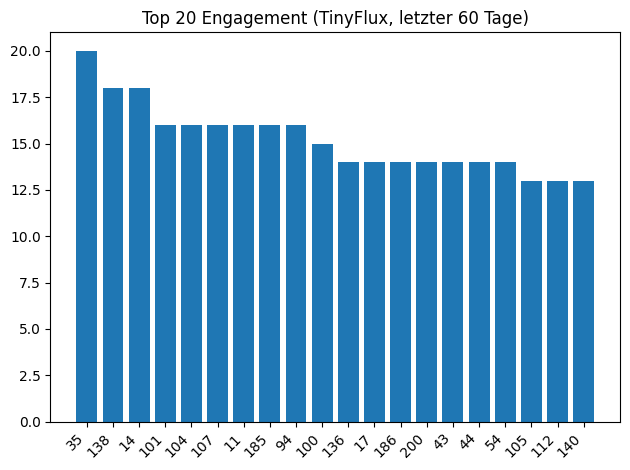

In [26]:
# Plot
plt.figure()
plt.bar(top['tag_user_id'].astype(str), top['engagement_score'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Engagement (TinyFlux, letzter 60 Tage)')
plt.tight_layout()

## Q2 – Beliebteste Posts (Likes pro Post)

In [27]:
df_all = df_from_points(db.all())
if df_all.empty or 'tag_type' not in df_all.columns:
    print('Keine Events vorhanden.')
else:
    likes = df_all[df_all['tag_type']=='like'].copy()
    if likes.empty or 'tag_post_id' not in likes.columns:
        print('Keine Like-Events mit post_id verfügbar.')
    else:
        top_posts = (likes.dropna(subset=['tag_post_id'])
                         .groupby('tag_post_id')
                         .size()
                         .reset_index(name='like_count')
                         .sort_values(['like_count','tag_post_id'], ascending=[False, True])
                         .head(20))
        show(top_posts, 10)

,tag_post_id,like_count
32,136,4
34,138,4
73,184,4
164,291,4
165,292,4
166,293,4
205,336,4
245,381,4
247,384,4
249,386,4


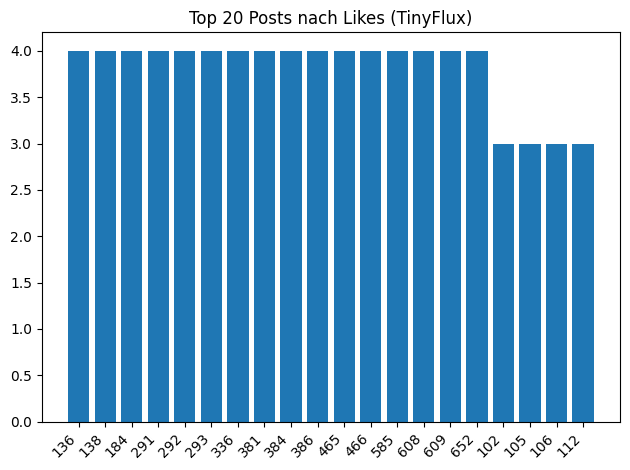

In [28]:
# Plot
plt.figure()
plt.bar(top_posts['tag_post_id'].astype(str), top_posts['like_count'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Posts nach Likes (TinyFlux)')
plt.tight_layout()

## Q3 – Trends über Zeit (Events/Tag, 7d Rolling)

In [29]:
import pandas as pd
df_all = df_from_points(db.all())
if df_all.empty:
    print('Keine Events vorhanden.')
else:
    df_all['day'] = pd.to_datetime(df_all['time']).dt.floor('D')
    trend = df_all.groupby('day').size().reset_index(name='events')
    trend['rolling_7d'] = trend['events'].rolling(7, min_periods=1).mean()
    show(trend, 10)

,day,events,rolling_7d
0,2025-01-24 00:00:00+00:00,20,20.000000
1,2025-01-25 00:00:00+00:00,19,19.500000
2,2025-01-26 00:00:00+00:00,15,18.000000
3,2025-01-27 00:00:00+00:00,18,18.000000
4,2025-01-28 00:00:00+00:00,11,16.600000
5,2025-01-29 00:00:00+00:00,15,16.333333
6,2025-01-30 00:00:00+00:00,13,15.857143
7,2025-01-31 00:00:00+00:00,15,15.142857
8,2025-02-01 00:00:00+00:00,11,14.000000
9,2025-02-02 00:00:00+00:00,13,13.714286


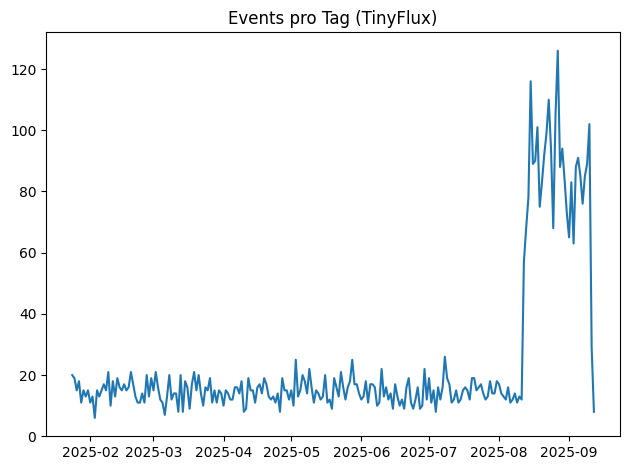

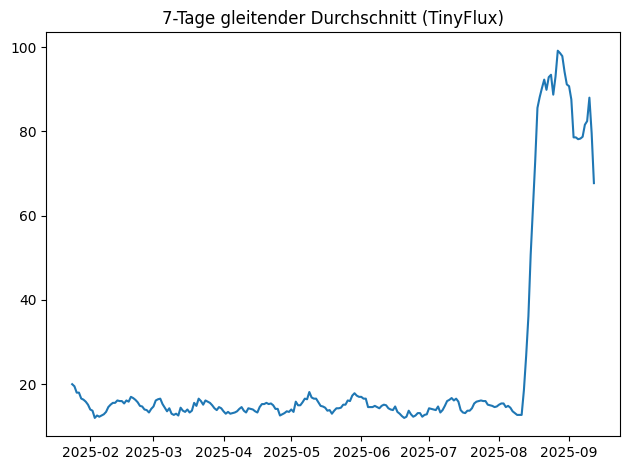

In [30]:
# Plots
plt.figure()
plt.plot(trend['day'], trend['events'])
plt.title('Events pro Tag (TinyFlux)')
plt.tight_layout()

plt.figure()
plt.plot(trend['day'], trend['rolling_7d'])
plt.title('7-Tage gleitender Durchschnitt (TinyFlux)')
plt.tight_layout()

## Q4 – Daily Active Users (DAU)

In [31]:
import pandas as pd
df_all = df_from_points(db.all())
if df_all.empty or 'tag_user_id' not in df_all.columns:
    print('Keine passenden Events vorhanden.')
else:
    df = df_all[df_all['tag_type'].isin(['post','comment','like'])].copy()
    df['day'] = pd.to_datetime(df['time']).dt.floor('D')
    dau = (df.dropna(subset=['tag_user_id'])
             .groupby('day')['tag_user_id'].nunique()
             .reset_index(name='dau'))
    dau['rolling_7d'] = dau['dau'].rolling(7, min_periods=1).mean()
    show(dau, 10)

,day,dau,rolling_7d
0,2025-08-12 00:00:00+00:00,24,24.000000
1,2025-08-13 00:00:00+00:00,39,31.500000
2,2025-08-14 00:00:00+00:00,44,35.666667
3,2025-08-15 00:00:00+00:00,67,43.500000
4,2025-08-16 00:00:00+00:00,54,45.600000
5,2025-08-17 00:00:00+00:00,50,46.333333
6,2025-08-18 00:00:00+00:00,54,47.428571
7,2025-08-19 00:00:00+00:00,44,50.285714
8,2025-08-20 00:00:00+00:00,47,51.428571
9,2025-08-21 00:00:00+00:00,52,52.571429


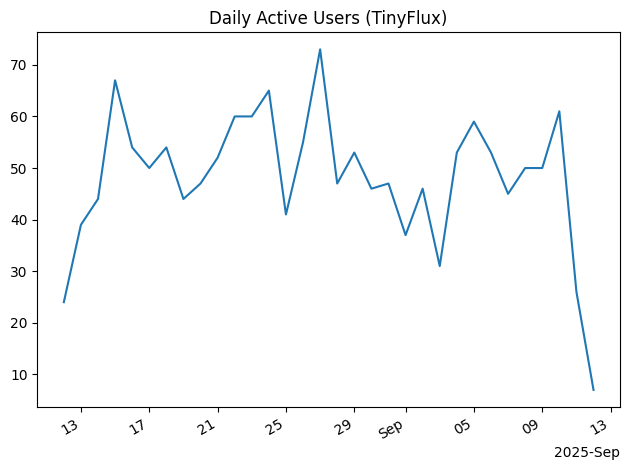

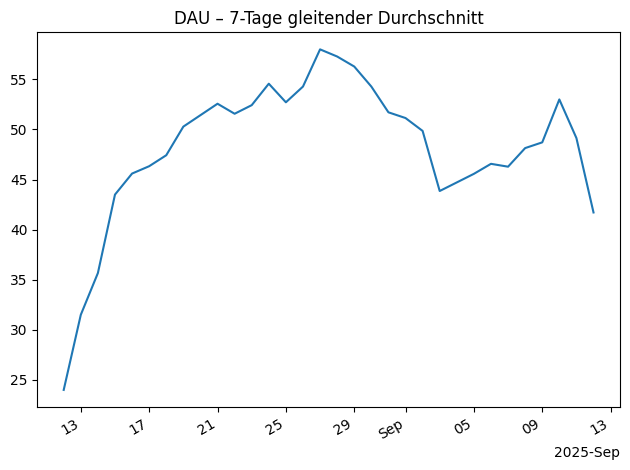

In [32]:
# Plots
plt.figure()
plt.plot(dau['day'], dau['dau'])
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.gcf().autofmt_xdate() 
plt.title('Daily Active Users (TinyFlux)')
plt.tight_layout()

plt.figure()
plt.plot(dau['day'], dau['rolling_7d'])
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.gcf().autofmt_xdate()
plt.title('DAU – 7-Tage gleitender Durchschnitt')
plt.tight_layout()

## Q5 – Feed-Fenster (Posts der Gefolgten in X Tagen)

,time,tag_post_id
85,2025-09-10 00:00:00+00:00,861
69,2025-09-10 00:00:00+00:00,372
54,2025-09-10 00:00:00+00:00,23
55,2025-09-10 00:00:00+00:00,46
56,2025-09-10 00:00:00+00:00,51
57,2025-09-10 00:00:00+00:00,57
58,2025-09-10 00:00:00+00:00,112
59,2025-09-10 00:00:00+00:00,122
60,2025-09-10 00:00:00+00:00,195
61,2025-09-10 00:00:00+00:00,210


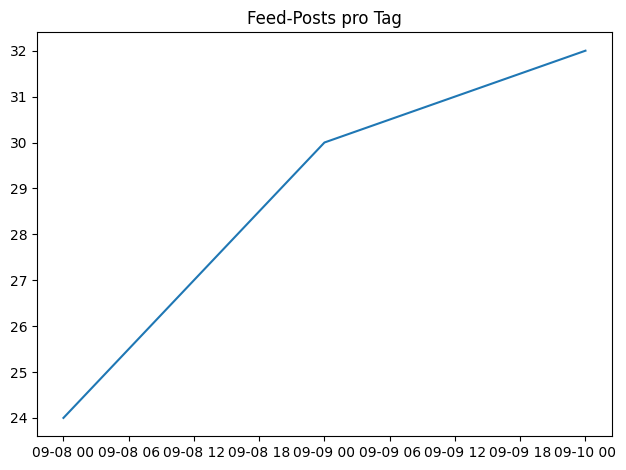

In [33]:
# Q5 · Feed-Fenster (Posts der Gefolgten) – robust (spaltenunabhängig)
viewer_user_id = 1
candidates_days = [3, 7, 14, 30, 90, 365]

now  = datetime.now(timezone.utc)
Time = TimeQuery(); Tag = TagQuery()

# Gefolgte als Strings
follows = pd.read_csv(REL / 'follows.csv')
followings = follows.loc[follows['src_user_id'] == viewer_user_id, 'dst_user_id'].astype(str).tolist()

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def filter_followings(df, followings):
    uid_col = pick_col(df, ['tag_user_id','user_id','tag_user','tag_src_user_id','src_user_id','tag_author_id','author_id'])
    if uid_col:
        return df[df[uid_col].astype(str).isin(followings)]
    return df

def ensure_post_id(df):
    pid_col = pick_col(df, ['tag_post_id','post_id','tag_post'])
    if pid_col:
        return df.dropna(subset=[pid_col]), pid_col
    return df, None

# 1) Zeitfenster schrittweise erweitern
df_feed = None
for d in candidates_days:
    q = (Time >= now - timedelta(days=d)) & (Tag.type == 'post')
    tmp = df_from_points(db.search(q))
    if tmp.empty:
        continue
    tmp = filter_followings(tmp, followings)
    tmp, pid_col = ensure_post_id(tmp)
    if not tmp.empty:
        df_feed = tmp.sort_values('time', ascending=False)
        break

# 2) Fallback: Neueste 100 Posts (Gefolgte, oder insgesamt wenn keine Spalten passend)
if df_feed is None or df_feed.empty:
    all_posts = df_from_points(db.search(Tag.type == 'post'))
    if not all_posts.empty:
        all_posts = filter_followings(all_posts, followings)
        all_posts, pid_col = ensure_post_id(all_posts)
        df_feed = all_posts.sort_values('time', ascending=False).head(100)

# Tabelle: die letzten 20 Feed-Posts (zeigt vorhandene ID-Spalte dynamisch)
if df_feed is None or df_feed.empty:
    print("Keine geeigneten Posts gefunden (auch nicht im Fallback).")
else:
    pid_col = pick_col(df_feed, ['tag_post_id','post_id','tag_post'])
    uid_col = pick_col(df_feed, ['tag_user_id','user_id','tag_user','tag_src_user_id','src_user_id','tag_author_id','author_id'])
    cols = ['time'] + ([uid_col] if uid_col else []) + ([pid_col] if pid_col else [])
    display(df_feed[cols].head(20))

    # Visualisierung A: Posts pro Tag
    df_plot = df_feed.copy()
    if 'time' in df_plot.columns:
        df_plot['day'] = pd.to_datetime(df_plot['time']).dt.floor('D')
        daily = df_plot.groupby('day').size().reset_index(name='posts')
        plt.figure(); plt.plot(daily['day'], daily['posts']); plt.title('Feed-Posts pro Tag'); plt.tight_layout()

    # Visualisierung B: Top-Autoren im Feed
    if uid_col:
        top_authors = df_feed[uid_col].astype(str).value_counts().head(10)
        plt.figure(); plt.bar(top_authors.index.astype(str), top_authors.values)
        plt.title('Top-Autoren (Feed)'); plt.xticks(rotation=45, ha='right'); plt.tight_layout()

## Zusammenfassung (Zeitreihenmodell · TinyFlux)

**Stärken**
- Sehr einfache, Python-native **Append-only**-Zeitreihenspeicherung; Timestamp-Queries sind erstklassig.
- Ideal für **Fensteranalysen** (gleitende Durchschnitte), **Downsampling** (täglich/wöchentlich), **Retention** (DAU).

**Schwächen (Use-Case-spezifisch)**
- Kein mächtiger Query Dialekt wie SQL/Cypher/Aggregation Pipelines; komplexe Joins/Graph-Analysen liegen außerhalb des Sweet Spots.
- Eher für **Edge/kleine Workloads** als für verteilte, hochvolumige Telemetrie gedacht.

**Merksatz**
> Zeitreihen-Datenbanken glänzen, wenn **Zeit** der primäre Filter ist. Für relationale Konsistenz, flexible Dokumente oder tiefe Graph-Fragen sind spezialisierte Modelle im Vorteil.
